# About

Based on the project:
https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy/notebook

I wanted to do something similar, but with my own database. The ideal would be not to have a database for a specific location, but to obtain the history of any location and be able to do the analysis of it.
I found an API which allows obtaining the historical data of the meteorological center closest to the given coordinates. This API belongs to:

https://dev.meteostat.net/

# Objetive:

The idea is to develop something simple for the user, which by copying the Google Maps link returns the forecast for the next day. This would be a start, and possibly other types of information could be forecast.

# Commercial context:
At this stage, its functionality is purely recreational. But if it works, it could be developed to obtain other types of information. For example, selling the amount of ml of rain or hours of sunshine in a given location, which could be useful for making decisions about crops or installing a solar panel, for example. It could also estimate the direction and strength of the wind to install windmills.

# Hypothesis:
Using historical climate data for a location and modeling techniques, a model can be developed that accurately predicts whether it will rain the next day.

# Libraries

In [ ]:
pip install meteostat

In [ ]:
pip install altair

In [ ]:
!pip install altair-viewer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 9.5 MB/s eta 0:00:00


In [ ]:
pip install seaborn ptitprince


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 4.5 MB/s eta 0:00:00
  Created wheel for ptitprince: filename=ptitprince-0.2.7-py3-none-any.whl size=10655 sha256=b66f1bbfaf5c8a4f30bdc5895cda1d601548d39c58978c88104b6e6eea566ca0
  Stored in directory: /root/.cache/pip/wheels/0e/43/31/e76a3bf61865543f076a9d9eb027a740caefb379424ecba4e8
Successfully built ptitprince
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2


In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import warnings
import re
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
# Import Meteostat library
from meteostat import Stations
from IPython.display import display, HTML
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import ptitprince as pt

# Place Google Maps location link

In [ ]:
# To obtain Coordinates, change the link between '' :
url_maps = 'https://www.google.com/maps/place/Centro+C%C3%ADvico+Bariloche/@-41.133496,-71.3102123,826m/data=!3m2!1e3!4b1!4m6!3m5!1s0x961a7b72dbb708e1:0xd91b7e92f820aa94!8m2!3d-41.133496!4d-71.3102123!16s%2Fg%2F12215pwy?entry=ttu&g_ep=EgoyMDI0MTEyNC4xIKXMDSoASAFQAw%3D%3D'

# Data Frame Creation

The raw dataframe is obtained from an API. For this, the longitude and latitude are given, the way it works is to search for the nearest weather station and return the dataframe with the historical data. To obtain the coordinates, the code uses regular expressions to search for them within the Google Maps link.

In [ ]:
#This step has the function of obtaining the coordinates within the link

def get_coordinates(url_maps):
    # Use a regular expression to find the pattern between '@' and the second ','
    pattern = r'@(-?[0-9.]+),(-?[0-9.]+)'
    match = re.search(pattern, url_maps)

    if match:
        # Convert the latitude and longitude to float (numerical values)
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        return latitude, longitude
    else:
        return None

coordinates = get_coordinates(url_maps)
if coordinates:
    latitude, longitude = coordinates
    print(f"Latitude: {latitude}, Longitude: {longitude}")
else:
    print("No coordinates found.")

Latitude: -41.133496, Longitude: -71.3102123


In [ ]:
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(latitude,longitude)
station = stations.fetch(1)

# Print DataFrame
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
87765,Bariloche Aerodrome,AR,R,87765,SAZS,-41.15,-71.1667,845.0,America/Argentina/Mendoza,1939-02-01,2024-12-02,1957-06-30,2024-12-30,1949-01-01,2022-01-01,12156.908196


In [ ]:
# Extract the 'id' from the index and assign it to station_id
station_id = station.index[0]
#Change station_id to string
station_id = str(station_id)

# Print the station_id
print(f"station_id "+station_id)

# Convert 'hourly_start' to datetime if it's not already in datetime format
station['hourly_start'] = pd.to_datetime(station['hourly_start'], errors='coerce')

# Extract the year from 'hourly_start'
year = station['hourly_start'].dt.year.iloc[0]

# Print the extracted year
print(year)

#Today Date
today = datetime.today()
today

station_id 87765
1939


datetime.datetime(2024, 12, 3, 19, 52, 12, 601444)

In [ ]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set time period
start = datetime(year, 1, 1)
end = today

# Fetch hourly data
try:
    data = Hourly(station_id, start, end)
    data = data.fetch()

    # Manually handle date parsing if necessary
    if 'time' in data.columns:  # Replace 'time' with the actual datetime column name if different
        data['time'] = pd.to_datetime(data['time'])



except Exception as e:
    print(f"An error occurred: {e}")

data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
1939-02-01 12:00:00,8.9,0.6,56.0,NaN,NaN,340.0,16.6,NaN,NaN,NaN,NaN
1939-02-02 12:00:00,10.0,5.6,74.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1939-02-03 12:00:00,11.1,9.4,89.0,NaN,NaN,340.0,3.6,NaN,NaN,NaN,NaN
1939-02-04 12:00:00,8.9,7.8,93.0,NaN,NaN,320.0,3.6,NaN,NaN,NaN,NaN
1939-02-06 12:00:00,7.8,3.8,76.0,NaN,NaN,180.0,9.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03 15:00:00,15.2,-2.7,29.0,0.0,NaN,304.0,16.7,NaN,1015.8,NaN,1.0
2024-12-03 16:00:00,16.8,-2.8,26.0,0.0,NaN,302.0,25.9,NaN,1012.9,NaN,1.0
2024-12-03 17:00:00,18.0,-3.5,23.0,0.0,NaN,300.0,27.8,NaN,1011.7,NaN,1.0


To predict rain, two columns are created, one indicating whether it rained that day, based on the prcp (precipitation) values, and another indicating whether it will rain tomorrow based on the previous one.

In [ ]:
df=data

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Create a new column with only the date (excluding the time)
df['date'] = df.index.date

# Sum daily precipitation by grouping by date
df['daily_precipitation'] = df.groupby('date')['prcp'].transform('sum')

# Add a new column 'daily_rain' with the value 'yes' if daily_precipitation > 1.0, otherwise 'no'
df['daily_rain'] = np.where(df['daily_precipitation'] > 1.0, 'yes', 'no')

# Sort the DataFrame by date to ensure proper grouping and shifting
df = df.sort_values(by='date')

# Create a new column with the 'daily_rain' value shifted by one day
df['next_day_rain'] = df.groupby('date')['daily_rain'].transform(lambda x: x.shift(-1))

# Now, fill in the next day's rain data from one day ahead
df['next_day_rain'] = df.groupby('date')['daily_rain'].transform('last').shift(-1)

In [ ]:
df

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
time,,,,,,,,,,,,,,,
1939-02-01 12:00:00,8.9,0.6,56.0,NaN,NaN,340.0,16.6,NaN,NaN,NaN,NaN,1939-02-01,0.0,no,no
1939-02-02 12:00:00,10.0,5.6,74.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1939-02-02,0.0,no,no
1939-02-03 12:00:00,11.1,9.4,89.0,NaN,NaN,340.0,3.6,NaN,NaN,NaN,NaN,1939-02-03,0.0,no,no
1939-02-04 12:00:00,8.9,7.8,93.0,NaN,NaN,320.0,3.6,NaN,NaN,NaN,NaN,1939-02-04,0.0,no,no
1939-02-06 12:00:00,7.8,3.8,76.0,NaN,NaN,180.0,9.4,NaN,NaN,NaN,NaN,1939-02-06,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03 01:00:00,11.0,1.0,50.0,0.0,NaN,280.0,28.0,NaN,1016.0,NaN,2.0,2024-12-03,0.0,no,no
2024-12-03 00:00:00,12.0,0.1,44.0,0.0,NaN,290.0,35.0,NaN,1016.0,NaN,2.0,2024-12-03,0.0,no,no
2024-12-03 18:00:00,19.4,-3.5,21.0,0.0,NaN,297.0,29.6,NaN,1013.0,NaN,1.0,2024-12-03,0.0,no,no


In [ ]:
# Reset the index to make 'time' a separate column and set a numeric index
df = df.reset_index()

# Now 'time' is a separate column, and the index is numeric by default

# Sort the DataFrame by the 'time' column to restore order
df = df.sort_values(by='time').reset_index(drop=True)

# Display the last 10 records of the re-sorted DataFrame
df.tail(24)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
342785,2024-12-02 20:00:00,17.0,-3.2,25.0,0.0,NaN,300.0,37.0,NaN,1015.0,NaN,2.0,2024-12-02,0.0,no,no
342786,2024-12-02 21:00:00,17.0,-3.7,24.0,0.0,NaN,290.0,39.0,NaN,1015.0,NaN,2.0,2024-12-02,0.0,no,no
342787,2024-12-02 22:00:00,16.0,-2.0,29.0,0.0,NaN,300.0,37.0,NaN,1015.0,NaN,2.0,2024-12-02,0.0,no,no
342788,2024-12-02 23:00:00,15.0,-2.0,31.0,0.0,NaN,290.0,32.0,NaN,1015.0,NaN,2.0,2024-12-02,0.0,no,no
342789,2024-12-03 00:00:00,12.0,0.1,44.0,0.0,NaN,290.0,35.0,NaN,1016.0,NaN,2.0,2024-12-03,0.0,no,no
342790,2024-12-03 01:00:00,11.0,1.0,50.0,0.0,NaN,280.0,28.0,NaN,1016.0,NaN,2.0,2024-12-03,0.0,no,no
342791,2024-12-03 02:00:00,10.0,2.1,58.0,0.0,NaN,320.0,22.0,NaN,1017.0,NaN,1.0,2024-12-03,0.0,no,no
342792,2024-12-03 03:00:00,9.0,2.1,62.0,0.0,NaN,290.0,26.0,NaN,1017.0,NaN,1.0,2024-12-03,0.0,no,no
342793,2024-12-03 04:00:00,7.0,1.1,66.0,0.0,NaN,250.0,11.0,NaN,1017.0,NaN,1.0,2024-12-03,0.0,no,no
342794,2024-12-03 05:00:00,5.0,-1.9,61.0,0.0,NaN,220.0,9.0,NaN,1017.0,NaN,1.0,2024-12-03,0.0,no,no


To obtain more columns (variables in the predictive model), the values ​​corresponding to hours 3, 6, 9, 12, 15, 18, 21 and 0 (or 24) are taken and the other schedules are eliminated.

In [ ]:
# Define the target hours
target_hours = [3, 6, 9, 12, 15, 18, 21, 0]

# Filter the DataFrame for rows where the hour in 'time' matches the target hours
df_filtered = df[df['time'].dt.hour.isin(target_hours)]

# Display the filtered DataFrame
df_filtered

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
0,1939-02-01 12:00:00,8.9,0.6,56.0,NaN,NaN,340.0,16.6,NaN,NaN,NaN,NaN,1939-02-01,0.0,no,no
1,1939-02-02 12:00:00,10.0,5.6,74.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1939-02-02,0.0,no,no
2,1939-02-03 12:00:00,11.1,9.4,89.0,NaN,NaN,340.0,3.6,NaN,NaN,NaN,NaN,1939-02-03,0.0,no,no
3,1939-02-04 12:00:00,8.9,7.8,93.0,NaN,NaN,320.0,3.6,NaN,NaN,NaN,NaN,1939-02-04,0.0,no,no
4,1939-02-06 12:00:00,7.8,3.8,76.0,NaN,NaN,180.0,9.4,NaN,NaN,NaN,NaN,1939-02-06,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342795,2024-12-03 06:00:00,2.0,-2.9,70.0,0.0,NaN,160.0,7.0,NaN,1017.0,NaN,1.0,2024-12-03,0.0,no,no
342798,2024-12-03 09:00:00,0.8,-3.7,72.0,0.0,NaN,186.0,5.5,NaN,1019.6,NaN,1.0,2024-12-03,0.0,no,no
342801,2024-12-03 12:00:00,8.6,-1.8,48.0,0.0,NaN,316.0,5.5,NaN,1018.5,NaN,1.0,2024-12-03,0.0,no,no
342804,2024-12-03 15:00:00,15.2,-2.7,29.0,0.0,NaN,304.0,16.7,NaN,1015.8,NaN,1.0,2024-12-03,0.0,no,no


In [ ]:
# Extract only the hour from the 'time' column
df_filtered['time'] = df_filtered['time'].dt.hour




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Display the DataFrame to verify the change
df_filtered.tail()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
342795,6,2.0,-2.9,70.0,0.0,NaN,160.0,7.0,NaN,1017.0,NaN,1.0,2024-12-03,0.0,no,no
342798,9,0.8,-3.7,72.0,0.0,NaN,186.0,5.5,NaN,1019.6,NaN,1.0,2024-12-03,0.0,no,no
342801,12,8.6,-1.8,48.0,0.0,NaN,316.0,5.5,NaN,1018.5,NaN,1.0,2024-12-03,0.0,no,no
342804,15,15.2,-2.7,29.0,0.0,NaN,304.0,16.7,NaN,1015.8,NaN,1.0,2024-12-03,0.0,no,no
342807,18,19.4,-3.5,21.0,0.0,NaN,297.0,29.6,NaN,1013.0,NaN,1.0,2024-12-03,0.0,no,no


## Formats & Units

# Time Format

Date and time statements follow the ISO 8601 standard (e.g. 2016-12-31 for December 31st 2016 and 23:59:58 for 23 hours, 59 minutes, and 58 seconds). The time zone used by Meteostat is Coordinated Universal Time (UTC).

#Time Ranges
Many JSON API endpoints require the specification of a time range using the start and end parameters. For these parameters please always provide dates in this format: YYYY-MM-DD.

#Meteorological Parameters
The Meteostat API uses abbreviations to describe meteorological parameters:

Code	Meaning
TEMP	Air Temperature
TAVG	Average Temperature
TMIN	Minimum Temperature
TMAX	Maximum Temperature
DWPT	Dew Point
PRCP	Total Precipitation
WDIR	Wind (From) Direction
WSPD	Average Wind Speed
WPGT	Wind Peak Gust
RHUM	Relative Humidity
PRES	Sea-Level Air Pressure
SNOW	Snow Depth
TSUN	Total Sunshine Duration
COCO	Weather Condition Code
#Meteorological Data Units
Parameter(s)	Unit
Temperature	°C
Precipitation	mm
Sunshine Duration	Minutes
Air Pressure	hPa
Wind Speed, Peak Wind Gust	km/h
Wind Direction	Degrees
Visibility, Cloud Height	m
Relative Humidity	%
#Weather Condition Codes
Hourly weather data may include information on the observed weather condition. Please note that the weather condition is not a key parameter for Meteostat. METAR reports, issued by weather stations located at airports, only report significant weather events. Also, some weather stations do not provide weather condition data at all.

Weather conditions are indicated by an integer value between 1 and 27 according to this list:


In [ ]:
# Create the Weather Condition Codes table
weather_condition_data = {
    'Code': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    'Weather Condition': [
        'Clear', 'Fair', 'Cloudy', 'Overcast', 'Fog', 'Freezing Fog',
        'Light Rain', 'Rain', 'Heavy Rain', 'Freezing Rain', 'Heavy Freezing Rain',
        'Sleet', 'Heavy Sleet', 'Light Snowfall', 'Snowfall', 'Heavy Snowfall',
        'Rain Shower', 'Heavy Rain Shower', 'Sleet Shower', 'Heavy Sleet Shower',
        'Snow Shower', 'Heavy Snow Shower', 'Lightning', 'Hail', 'Thunderstorm',
        'Heavy Thunderstorm', 'Storm'
    ]
}

# Convert it to a DataFrame
weather_condition_df = pd.DataFrame(weather_condition_data)

# Display the DataFrame
weather_condition_df

,Code,Weather Condition
0,1,Clear
1,2,Fair
2,3,Cloudy
3,4,Overcast
4,5,Fog
5,6,Freezing Fog
6,7,Light Rain
7,8,Rain
8,9,Heavy Rain
9,10,Freezing Rain


# Data selection and cleaning

Not all dates have all Hours (old records). Therefore, in order for the dataset to be as complete and homogeneous as possible, the dates in which this condition is not met are eliminated.

In [ ]:
# Group by 'date' and count the number of rows for each date
date_counts = df_filtered.groupby('date').size().reset_index(name='count')

# Display the resulting table
date_counts

,date,count
0,1939-02-01,1
1,1939-02-02,1
2,1939-02-03,1
3,1939-02-04,1
4,1939-02-06,1
...,...,...
22723,2024-11-29,8
22724,2024-11-30,8
22725,2024-12-01,8
22726,2024-12-02,8


In [ ]:
# Get all dates where the count is not equal to 8
dates_to_remove = date_counts[date_counts['count'] != 8]['date']

# Filter out rows in df_filtered where 'date' is in dates_to_remove
df_filtered = df_filtered[~df_filtered['date'].isin(dates_to_remove)]

# Display the updated df_filtered
df_filtered


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
9167,0,15.0,7.1,59.0,NaN,NaN,290.0,40.7,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9168,3,18.0,10.1,60.0,NaN,NaN,140.0,18.4,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9169,6,10.0,7.9,87.0,NaN,NaN,290.0,20.2,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9171,9,5.0,3.0,87.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9173,12,9.0,4.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342774,9,4.0,-5.0,52.0,0.0,NaN,270.0,13.0,NaN,1016.0,NaN,2.0,2024-12-02,0.0,no,no
342777,12,8.0,-5.8,37.0,0.0,NaN,310.0,22.0,NaN,1017.0,NaN,2.0,2024-12-02,0.0,no,no
342780,15,12.0,-5.1,30.0,0.0,NaN,300.0,26.0,NaN,1017.0,NaN,2.0,2024-12-02,0.0,no,no
342783,18,16.0,-7.0,20.0,0.0,NaN,320.0,33.0,NaN,1016.0,NaN,2.0,2024-12-02,0.0,no,no


Many locations take more data as time goes by, so the most complete information will always be the most recent. This is why, to handle nulls, the first non-null value of each column is searched for and the previous records are eliminated. This is done sequentially for each column, and if the entire column has no values, it is completely eliminated. The prcp column is a special case, since it is the main column for the project, so if it has no values, a message appears stating that this location is not useful for the project.

In [ ]:
# Check if there are any non-NaN values in the 'prcp' column
if df_filtered['prcp'].notna().any():
    # Find the first date where 'prcp' is not NaN
    first_date_with_prcp = df_filtered[df_filtered['prcp'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_prcp]
    # Display the result
    print("First date with prcp data:", first_date_with_prcp)
else:
    # If all values are NaN, drop the 'prcp' column and display an alert message
    df_filtered = df_filtered.drop(columns=['prcp'])
    display(HTML("""
        <h3 style="color:red;">Dataset Incompatible for Rain Forecasting</h3>
        <p>The dataset does not contain any precipitation ('prcp') data. Please select a different location to forecast rain.</p>
    """))
    # Stop further execution in the notebook
    sys.exit("Execution stopped due to missing precipitation data.")


First date with prcp data: 2022-05-24


In [ ]:
# Check if there are any non-NaN values in the 'wpgt' column
if df_filtered['wpgt'].notna().any():
    # Find the first date where 'wpgt' is not NaN
    first_date_with_wpgt = df_filtered[df_filtered['wpgt'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_wpgt]
    # Display the result
    print("First date with wpgt data:", first_date_with_wpgt)
else:
    # If all values are NaN, drop the 'wpgt' column
    df_filtered = df_filtered.drop(columns=['wpgt'])
    print("'wpgt' column has been removed due to all values being NaN.")

'wpgt' column has been removed due to all values being NaN.


In [ ]:
# Check if there are any non-NaN values in the 'snow' column
if df_filtered['snow'].notna().any():
    # Find the first date where 'snow' is not NaN
    first_date_with_snow = df_filtered[df_filtered['snow'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_snow]
    # Display the result
    print("First date with snow data:", first_date_with_snow)
else:
    # If all values are NaN, drop the 'snow' column
    df_filtered = df_filtered.drop(columns=['snow'])
    print("'snow' column has been removed due to all values being NaN.")

'snow' column has been removed due to all values being NaN.


In [ ]:
# Check if there are any non-NaN values in the 'tsun' column
if df_filtered['tsun'].notna().any():
    # Find the first date where 'tsun' is not NaN
    first_date_with_tsun = df_filtered[df_filtered['tsun'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_tsun]
    # Display the result
    print("First date with tsun data:", first_date_with_tsun)
else:
    # If all values are NaN, drop the 'tsun' column
    df_filtered = df_filtered.drop(columns=['tsun'])
    print("'tsun' column has been removed due to all values being NaN.")


'tsun' column has been removed due to all values being NaN.


In [ ]:
# Check if there are any non-NaN values in the 'coco' column
if df_filtered['coco'].notna().any():
    # Find the first date where 'coco' is not NaN
    first_date_with_coco = df_filtered[df_filtered['coco'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_coco]
    # Display the result
    print("First date with coco data:", first_date_with_coco)
else:
    # If all values are NaN, drop the 'coco' column
    df_filtered = df_filtered.drop(columns=['coco'])
    print("'coco' column has been removed due to all values being NaN.")


First date with coco data: 2022-05-24


In [ ]:
df_filtered

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,date,daily_precipitation,daily_rain,next_day_rain
320613,0,2.7,0.3,84.0,NaN,290.0,29.5,1008.0,8.0,2022-05-24,4.2,yes,yes
320616,3,1.6,0.1,90.0,NaN,270.0,11.2,1009.0,7.0,2022-05-24,4.2,yes,yes
320619,6,3.2,0.8,84.0,NaN,320.0,25.9,1008.0,7.0,2022-05-24,4.2,yes,yes
320622,9,2.8,-1.0,76.0,NaN,290.0,40.7,1013.0,7.0,2022-05-24,4.2,yes,yes
320625,12,2.3,-0.1,84.0,NaN,290.0,35.3,1010.0,8.0,2022-05-24,4.2,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342774,9,4.0,-5.0,52.0,0.0,270.0,13.0,1016.0,2.0,2024-12-02,0.0,no,no
342777,12,8.0,-5.8,37.0,0.0,310.0,22.0,1017.0,2.0,2024-12-02,0.0,no,no
342780,15,12.0,-5.1,30.0,0.0,300.0,26.0,1017.0,2.0,2024-12-02,0.0,no,no
342783,18,16.0,-7.0,20.0,0.0,320.0,33.0,1016.0,2.0,2024-12-02,0.0,no,no


Nulls in the raw original dataframe

In [ ]:
# Count the number of NaN values in each column of df
nan_counts = df.isna().sum()

# Display the result
nan_counts



,0
time,0
temp,4532
dwpt,6561
rhum,6561
prcp,320815
snow,342809
wdir,57359
wspd,2346
wpgt,342809
pres,264091


<Axes: >

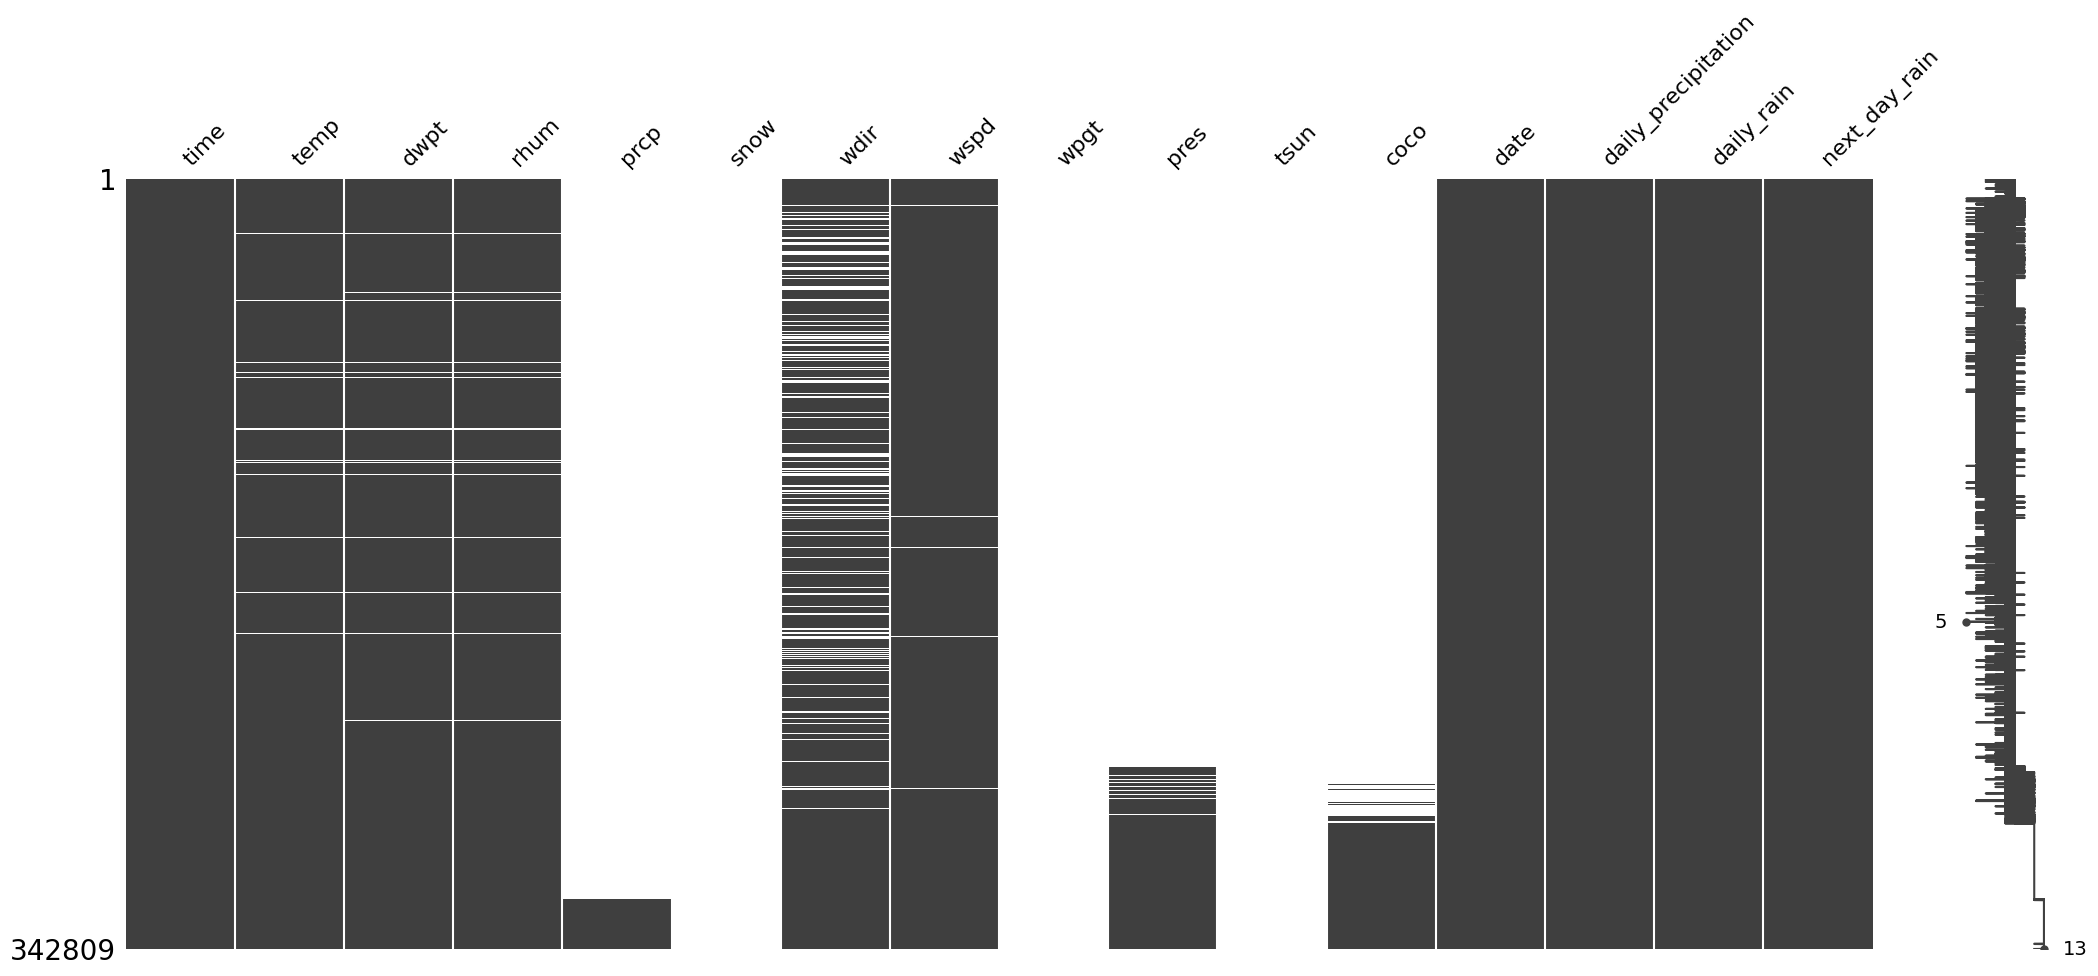

In [ ]:
msno.matrix(df)

Nulls in the filtered dataframe

In [ ]:
# Count the number of NaN values in each column of df_filtered
nan_counts = df_filtered.isna().sum()

# Display the result
nan_counts

,0
time,0
temp,0
dwpt,0
rhum,0
prcp,67
wdir,0
wspd,0
pres,0
coco,73
date,0


<Axes: >

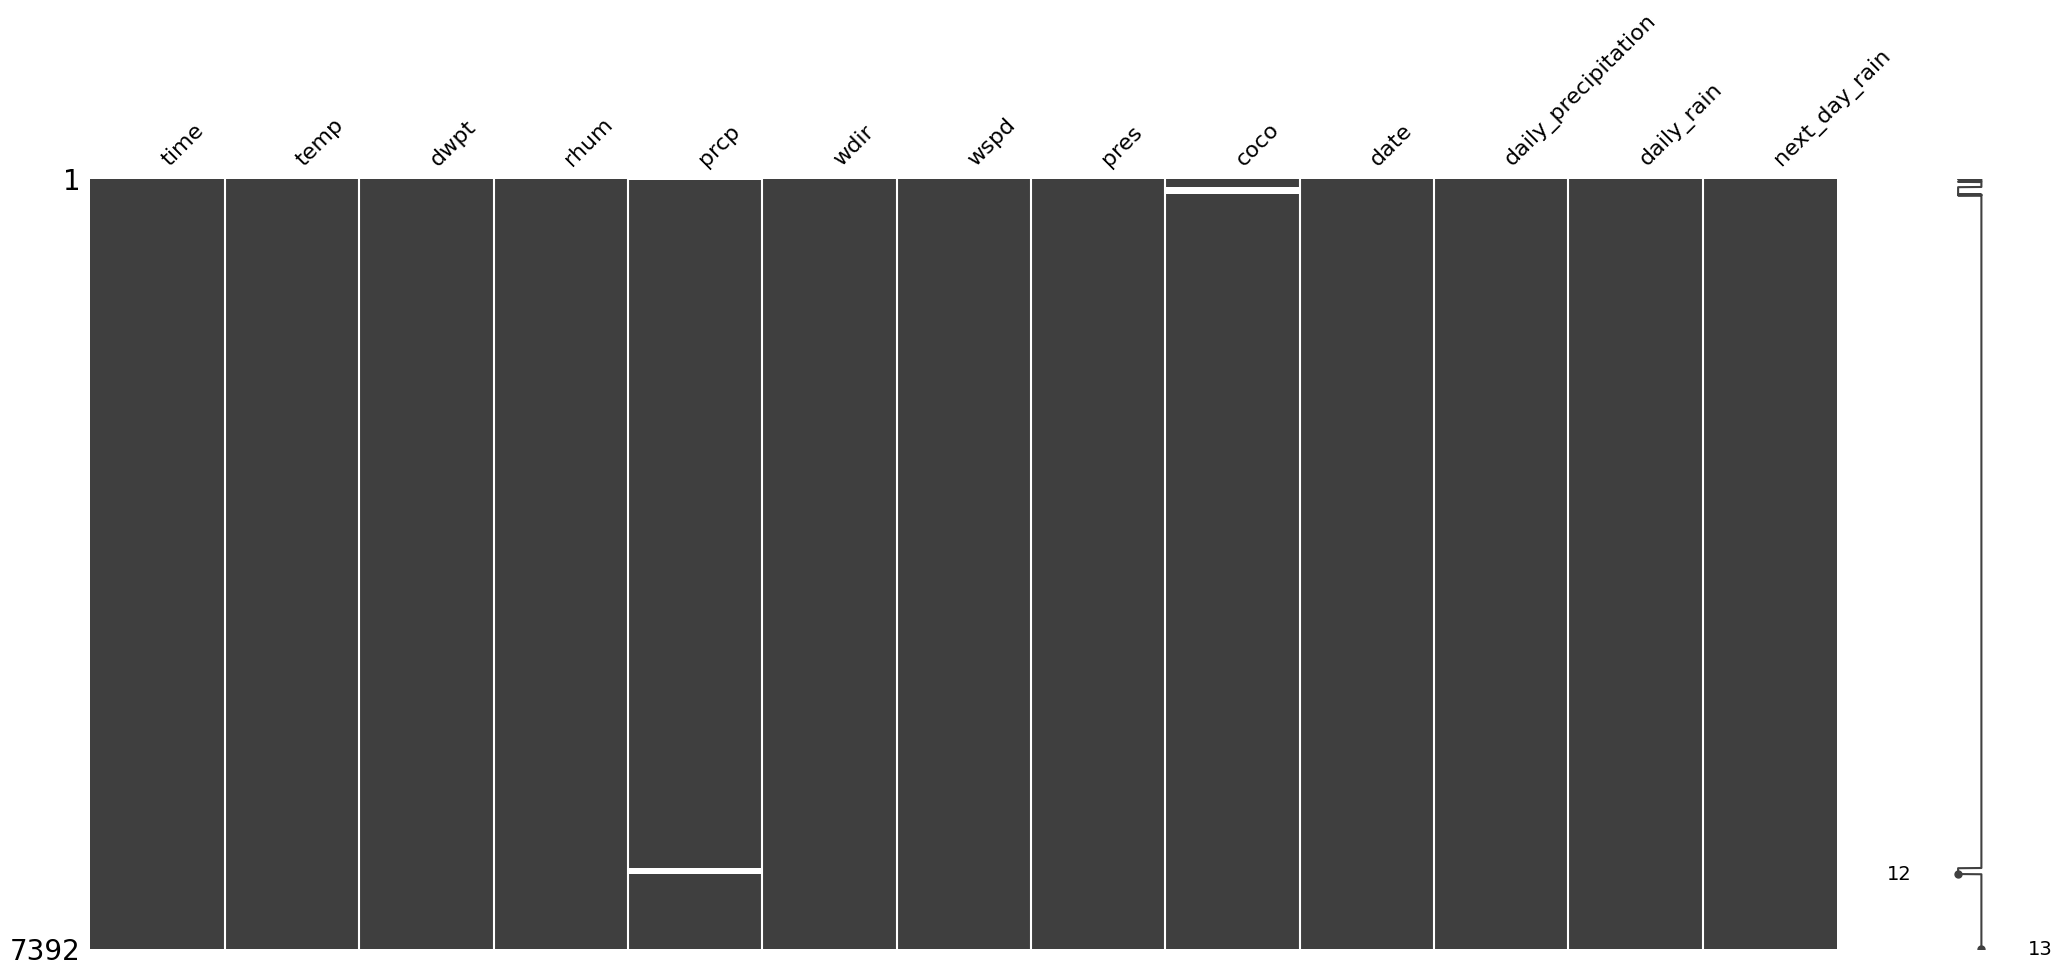

In [ ]:
msno.matrix(df_filtered)

Nulls are filled with 0, assuming that the lack of data is due to the lack of positive records. For example, if there was no snow, they leave it empty. The only column that is filled with another value is the wind direction, which is filled with 365. It takes the value but does not appear on the graphic.

In [ ]:
# Define the columns and values for filling NaNs
fill_values = {
    'prcp': 0,
    'snow': 0,
    'wspd': 0,
    'wpgt': 0,
    'tsun': 0,
    'coco': 0,
    'wdir': 365
}

# Fill NaNs only in the columns that exist in df_filtered
for column, value in fill_values.items():
    if column in df_filtered.columns:
        df_filtered[column].fillna(value, inplace=True)

# Display the updated DataFrame
df_filtered


,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,date,daily_precipitation,daily_rain,next_day_rain
320613,0,2.7,0.3,84.0,0.0,290.0,29.5,1008.0,8.0,2022-05-24,4.2,yes,yes
320616,3,1.6,0.1,90.0,0.0,270.0,11.2,1009.0,7.0,2022-05-24,4.2,yes,yes
320619,6,3.2,0.8,84.0,0.0,320.0,25.9,1008.0,7.0,2022-05-24,4.2,yes,yes
320622,9,2.8,-1.0,76.0,0.0,290.0,40.7,1013.0,7.0,2022-05-24,4.2,yes,yes
320625,12,2.3,-0.1,84.0,0.0,290.0,35.3,1010.0,8.0,2022-05-24,4.2,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342774,9,4.0,-5.0,52.0,0.0,270.0,13.0,1016.0,2.0,2024-12-02,0.0,no,no
342777,12,8.0,-5.8,37.0,0.0,310.0,22.0,1017.0,2.0,2024-12-02,0.0,no,no
342780,15,12.0,-5.1,30.0,0.0,300.0,26.0,1017.0,2.0,2024-12-02,0.0,no,no
342783,18,16.0,-7.0,20.0,0.0,320.0,33.0,1016.0,2.0,2024-12-02,0.0,no,no


Once the data is ready, the pivoting is done to have one row per day and the values ​​for each hour are represented as individual columns. This helps to have more columns and therefore more variables to use with the models.

In [ ]:
# List of columns to exclude from pivoting
exclude_columns = ['date', 'time', 'daily_precipitation', 'daily_rain', 'next_day_rain']

# Separate columns to be duplicated and columns to pivot
fixed_columns = ['daily_precipitation', 'daily_rain', 'next_day_rain']
pivot_columns = [col for col in df_filtered.columns if col not in exclude_columns]

# Set the index to 'date' and 'time' to prepare for pivoting
df_filtered.set_index(['date', 'time'], inplace=True)

# Pivot the DataFrame, renaming columns with the hour suffix
df_pivoted = df_filtered[pivot_columns].unstack(level=-1)
df_pivoted.columns = [f"{col}_{int(hour)}" for col, hour in df_pivoted.columns]

# Reset the index to bring 'date' back as a column
df_pivoted.reset_index(inplace=True)

# Add the fixed columns (which are consistent across the day) to the new DataFrame
for col in fixed_columns:
    df_pivoted[col] = df_filtered.groupby('date')[col].first().values




In [ ]:
# Display the new table
df_pivoted

,date,temp_0,temp_3,temp_6,temp_9,temp_12,temp_15,temp_18,temp_21,dwpt_0,...,coco_3,coco_6,coco_9,coco_12,coco_15,coco_18,coco_21,daily_precipitation,daily_rain,next_day_rain
0,2022-05-24,2.7,1.6,3.2,2.8,2.3,1.4,3.3,3.1,0.3,...,7.0,7.0,7.0,8.0,8.0,8.0,7.0,4.2,yes,yes
1,2022-05-25,2.4,1.3,-1.9,-3.6,-5.0,-0.4,3.1,3.6,0.5,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,no,no
2,2022-05-26,-2.0,-5.2,-6.8,-8.1,-5.9,-1.7,1.0,0.5,-4.7,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,no,no
3,2022-05-27,-3.1,-4.8,-6.8,-4.4,-3.7,-0.9,1.7,2.7,-5.3,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,no,no
4,2022-05-28,-2.4,-4.2,-5.4,-7.5,-6.1,-0.4,3.7,2.4,-5.5,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2024-11-28,8.0,6.0,6.0,5.0,8.0,11.0,14.0,14.0,0.9,...,3.0,2.0,2.0,2.0,3.0,2.0,2.0,1.1,yes,yes
920,2024-11-29,10.0,7.0,6.0,1.0,8.0,15.0,21.0,21.0,1.1,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,no,no
921,2024-11-30,17.0,9.0,6.0,3.0,11.0,18.0,20.0,17.0,2.9,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,no,no
922,2024-12-01,12.0,9.0,8.0,7.0,7.0,12.0,14.0,13.0,1.0,...,1.0,1.0,3.0,3.0,3.0,2.0,2.0,1.0,no,no


In [ ]:
# Count the number of NaN values in each column of df_pivoted
nan_counts = df_pivoted.isna().sum()

# Display the result
nan_counts

,0
date,0
temp_0,0
temp_3,0
temp_6,0
temp_9,0
...,...
coco_18,0
coco_21,0
daily_precipitation,0
daily_rain,0


# Descriptive statistics

Due to the nature of the project, all data will change based on the location of analysis. So they will be shown but not mentioned in detail as it changes with each location.

In [ ]:
#Row Count, Column Count
df_pivoted.shape

(924, 68)

In [ ]:
#Counting duplicates
df_pivoted.duplicated().value_counts()

,count
False,924


In [ ]:
#Table Info
df_pivoted.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 68 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 924 non-null    object 
 1   temp_0               924 non-null    float64
 2   temp_3               924 non-null    float64
 3   temp_6               924 non-null    float64
 4   temp_9               924 non-null    float64
 5   temp_12              924 non-null    float64
 6   temp_15              924 non-null    float64
 7   temp_18              924 non-null    float64
 8   temp_21              924 non-null    float64
 9   dwpt_0               924 non-null    float64
 10  dwpt_3               924 non-null    float64
 11  dwpt_6               924 non-null    float64
 12  dwpt_9               924 non-null    float64
 13  dwpt_12              924 non-null    float64
 14  dwpt_15              924 non-null    float64
 15  dwpt_18              924 non-null    flo

# Categorical columns

In [ ]:
df_pivoted.describe(include = 'object').T

,count,unique,top,freq
date,924,924,2022-05-24,1
daily_rain,924,2,no,645
next_day_rain,924,2,no,639


It should be noted that there are other categorical columns but since they are represented by numerical values ​​they will appear as numeric.

# Numeric Columns

In [ ]:
df_pivoted.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_0,924.0,8.552706,6.727108,-3.1,3.175,7.20,13.100,31.4
temp_3,924.0,6.413420,5.626769,-5.3,2.000,5.60,10.700,22.8
temp_6,924.0,4.870238,5.104328,-7.0,1.075,4.40,8.425,20.3
temp_9,924.0,3.813312,4.851994,-8.1,0.375,3.25,7.000,18.5
temp_12,924.0,5.894264,6.205525,-8.2,1.275,5.05,10.700,23.5
...,...,...,...,...,...,...,...,...
coco_12,924.0,3.590909,3.108957,0.0,2.000,3.00,4.000,16.0
coco_15,924.0,3.536797,3.186807,0.0,2.000,3.00,3.000,19.0
coco_18,924.0,3.451299,2.989111,0.0,2.000,3.00,3.000,19.0
coco_21,924.0,3.669913,3.233144,0.0,2.000,3.00,3.000,21.0


As mentioned in the previous point, some columns present at this point are actually categorical, but converted into numerical values ​​to use the models.

# Graphic representations

Minimum, Maximum, and Average Temperature(temp) by Hour

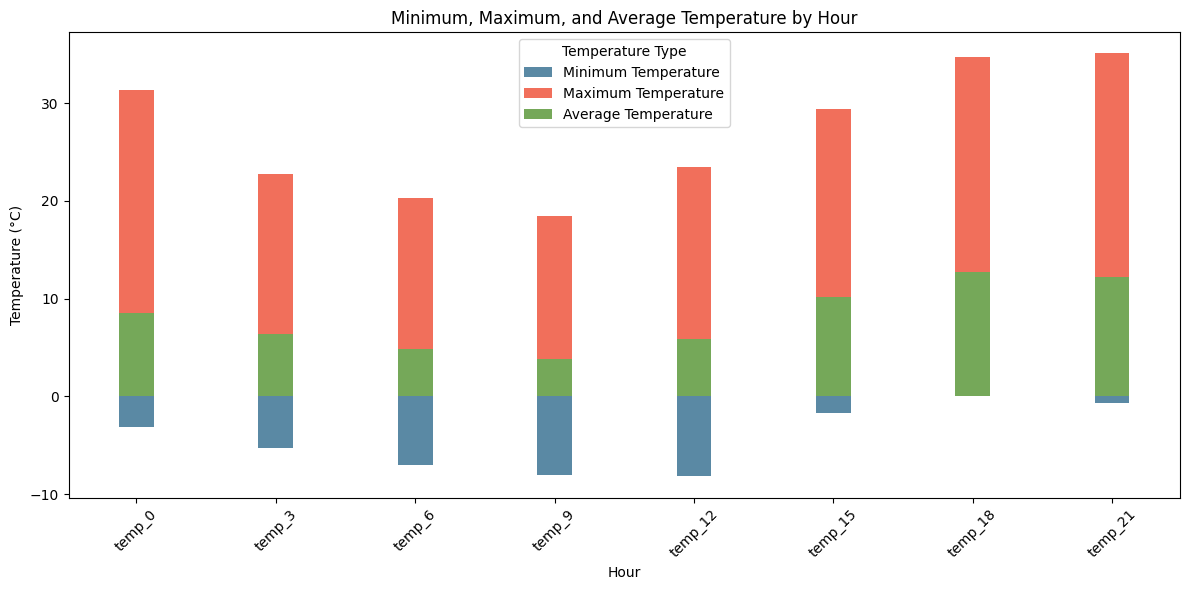

In [ ]:
# List of temperature columns
cols = ['temp_0', 'temp_3', 'temp_6', 'temp_9', 'temp_12', 'temp_15', 'temp_18', 'temp_21']

# Get the minimum, maximum, and average values for each column
min_values = df_pivoted[cols].min()
max_values = df_pivoted[cols].max()
avg_values = df_pivoted[cols].mean()

# Combine these values into a single DataFrame
temperature_values = pd.DataFrame({
    'Hour': min_values.index.tolist() * 3,
    'Temperature': pd.concat([min_values, max_values, avg_values], axis=0),
    'Type': ['Minimum Temperature'] * len(min_values) + ['Maximum Temperature'] * len(max_values) + ['Average Temperature'] * len(avg_values)
})

# Plot the result
plt.figure(figsize=(12, 6))

# Softer, more subdued colors for the temperature types
colors = {'Minimum Temperature': '#5A89A4', 'Maximum Temperature': '#F16F5B', 'Average Temperature': '#75A859'}

for label in temperature_values['Type'].unique():
    subset = temperature_values[temperature_values['Type'] == label]
    # Adjust zorder: minimum in front (highest), average in the middle, maximum behind (lowest)
    zorder = 3 if label == 'Minimum Temperature' else (2 if label == 'Average Temperature' else 1)
    plt.bar(subset['Hour'], subset['Temperature'], label=label, color=colors[label], width=0.25, align='center', zorder=zorder)

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.title('Minimum, Maximum, and Average Temperature by Hour')
plt.xticks(rotation=45)
plt.legend(title="Temperature Type")
plt.tight_layout()
plt.show()

Relative Humidity(rhum)

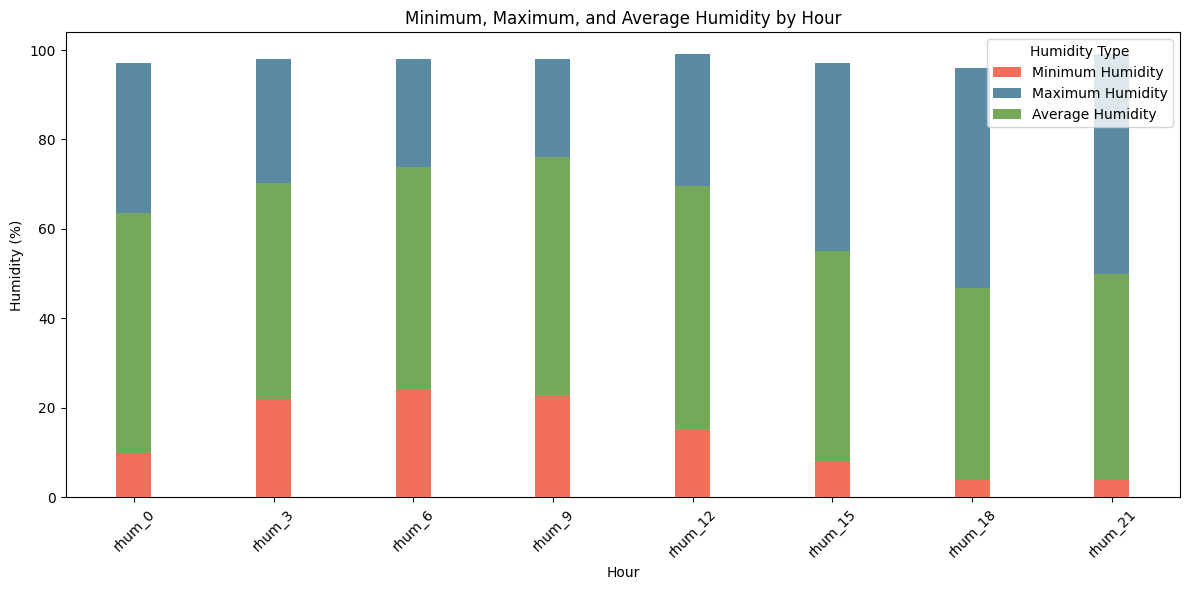

In [ ]:
# List of humidity columns (replace these with your actual RHUM columns)
cols = ['rhum_0', 'rhum_3', 'rhum_6', 'rhum_9', 'rhum_12', 'rhum_15', 'rhum_18', 'rhum_21']

# Get the minimum, maximum, and average values for each RHUM column
min_values = df_pivoted[cols].min()
max_values = df_pivoted[cols].max()
avg_values = df_pivoted[cols].mean()

# Combine these values into a single DataFrame
humidity_values = pd.DataFrame({
    'Hour': min_values.index.tolist() * 3,
    'Humidity': pd.concat([min_values, max_values, avg_values], axis=0),
    'Type': ['Minimum Humidity'] * len(min_values) + ['Maximum Humidity'] * len(max_values) + ['Average Humidity'] * len(avg_values)
})

# Plot the result
plt.figure(figsize=(12, 6))

# Softer, more subdued colors for the humidity types
colors = {'Minimum Humidity': '#F16F5B', 'Maximum Humidity': '#5A89A4', 'Average Humidity': '#75A859'}

for label in humidity_values['Type'].unique():
    subset = humidity_values[humidity_values['Type'] == label]
    # Adjust zorder: minimum in front (highest), average in the middle, maximum behind (lowest)
    zorder = 3 if label == 'Minimum Humidity' else (2 if label == 'Average Humidity' else 1)
    plt.bar(subset['Hour'], subset['Humidity'], label=label, color=colors[label], width=0.25, align='center', zorder=zorder)

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Minimum, Maximum, and Average Humidity by Hour')
plt.xticks(rotation=45)
plt.legend(title="Humidity Type")
plt.tight_layout()
plt.show()


Variation in precipitation for each month

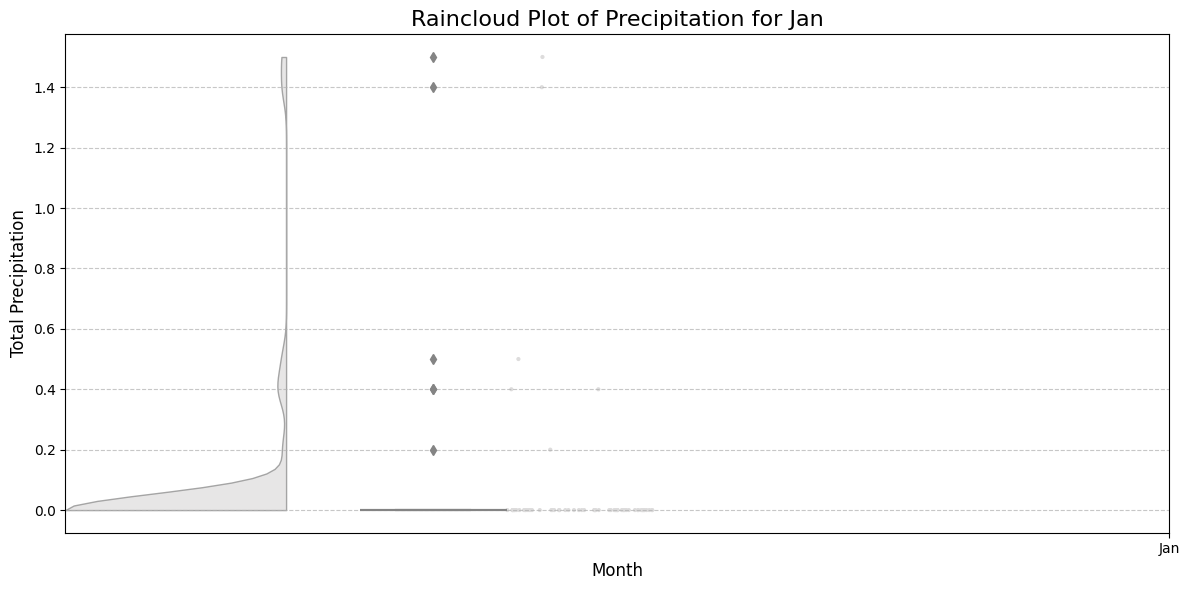

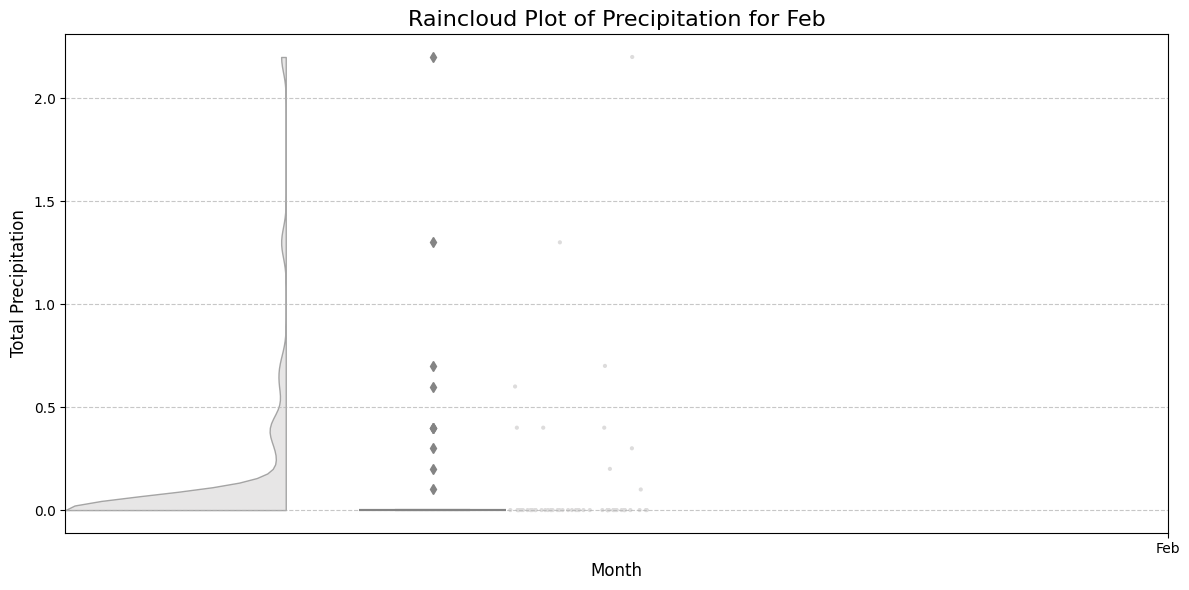

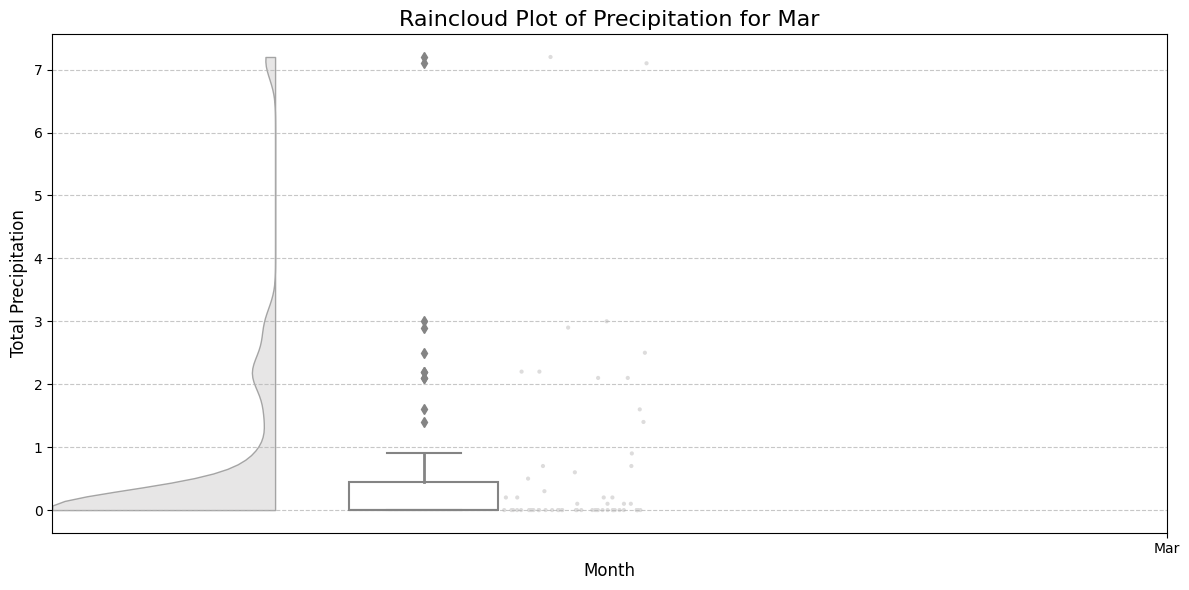

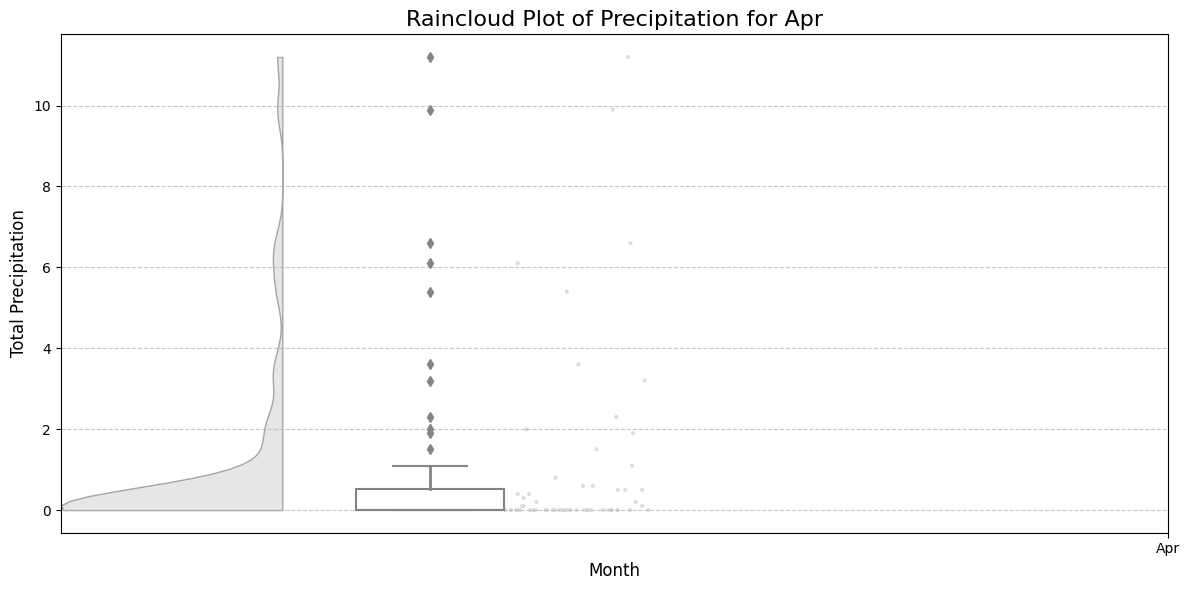

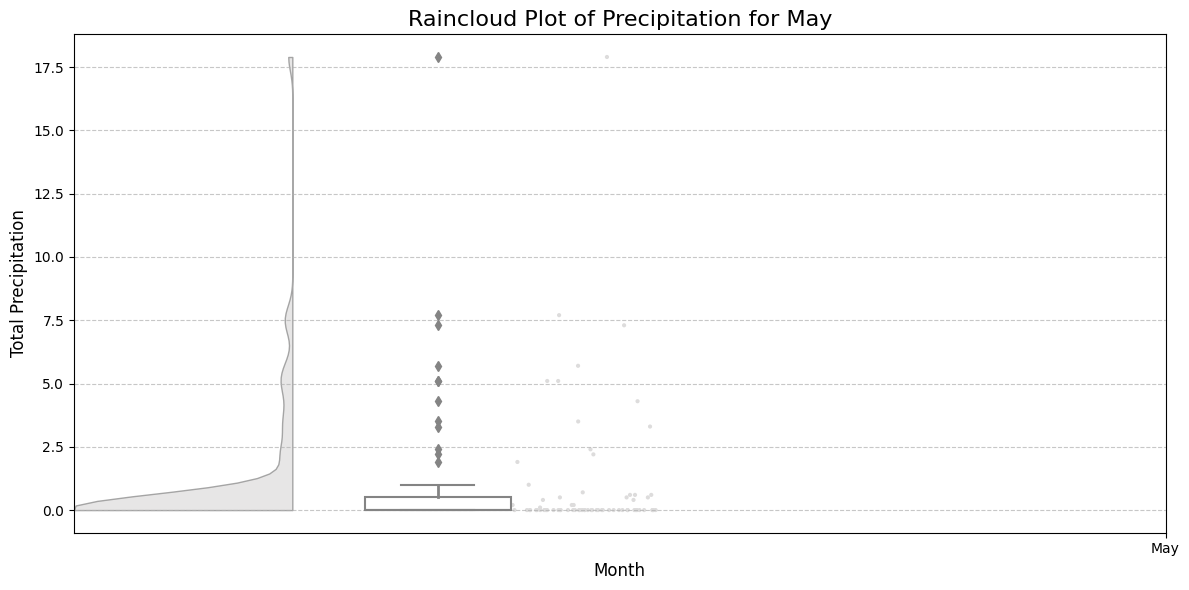

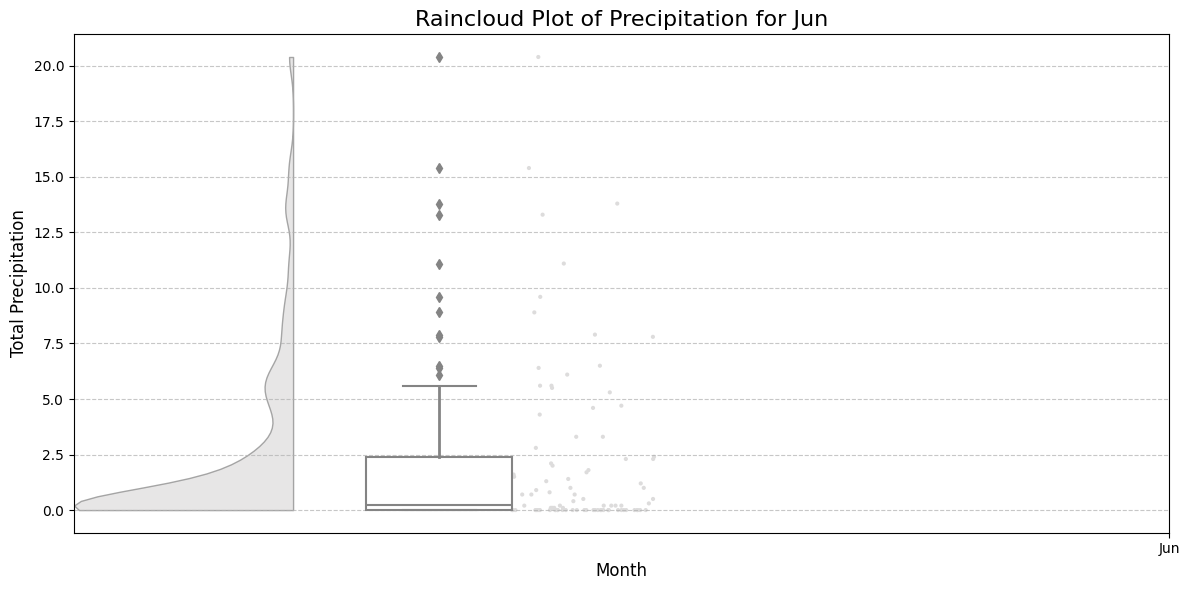

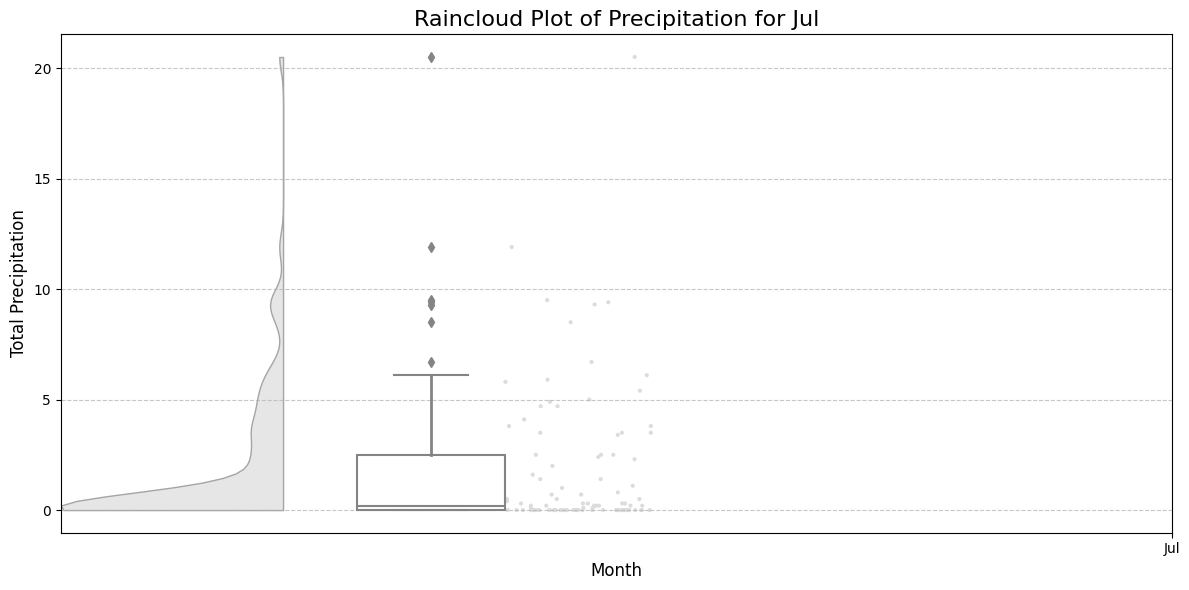

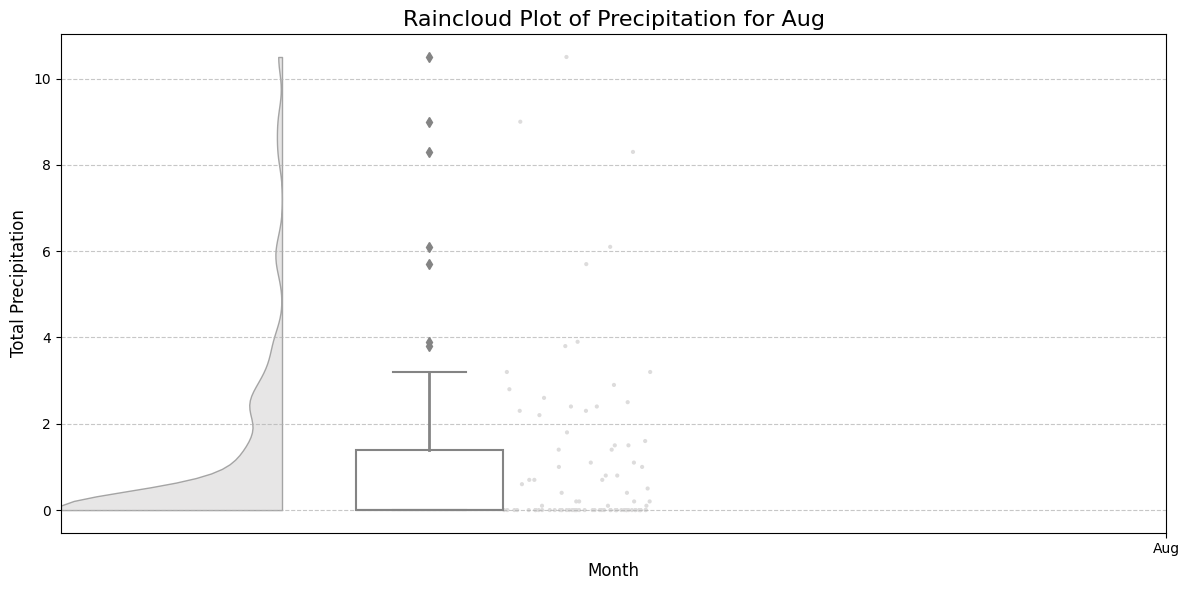

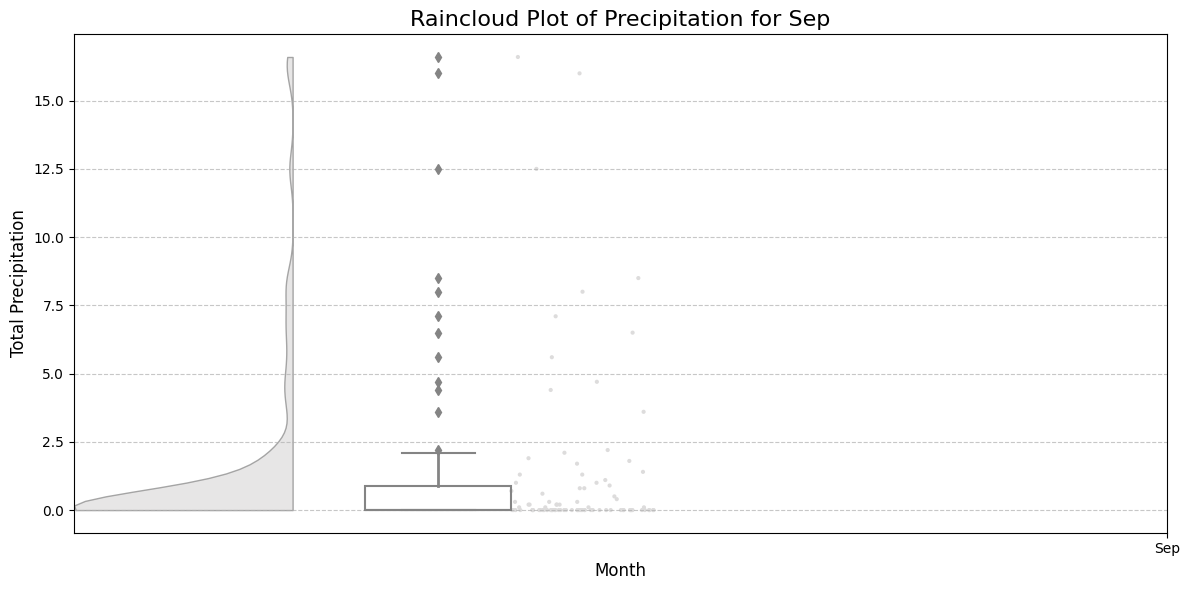

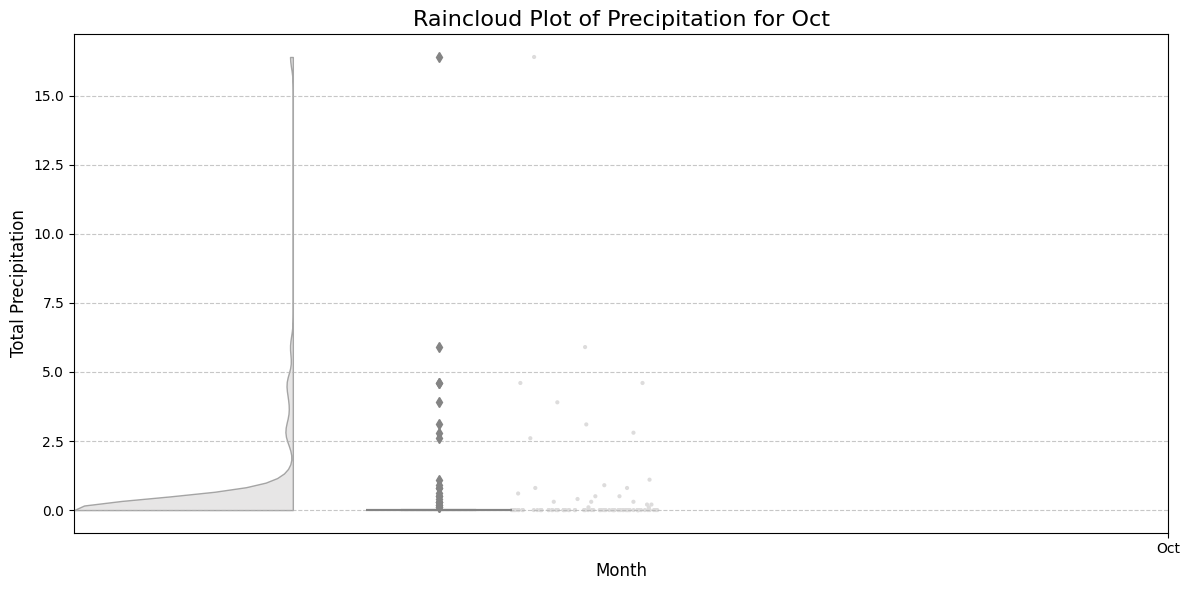

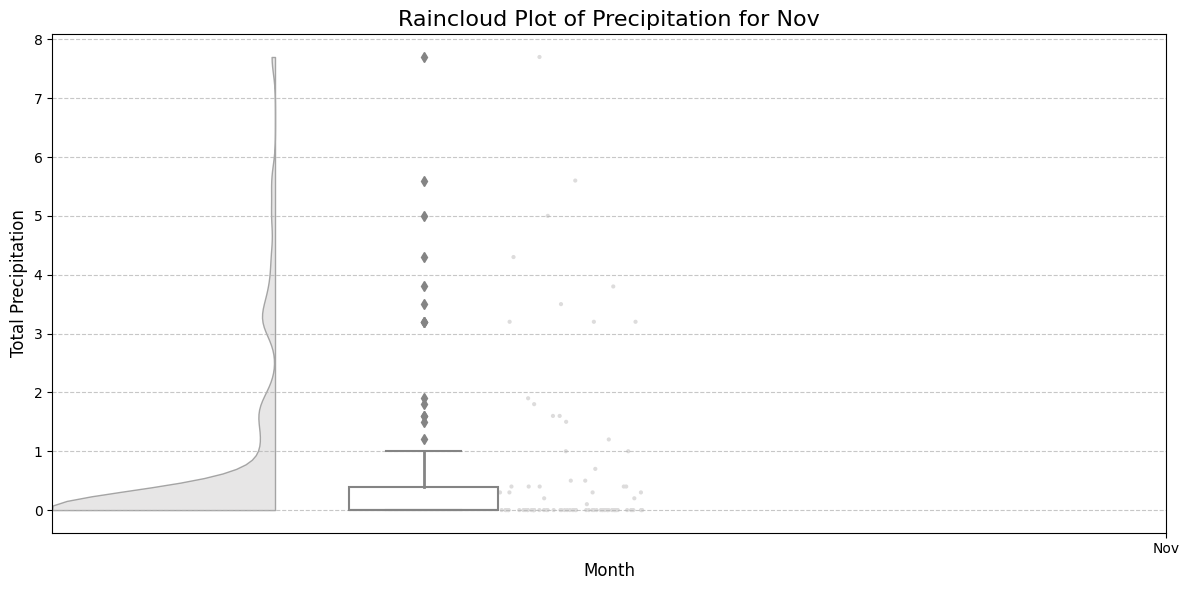

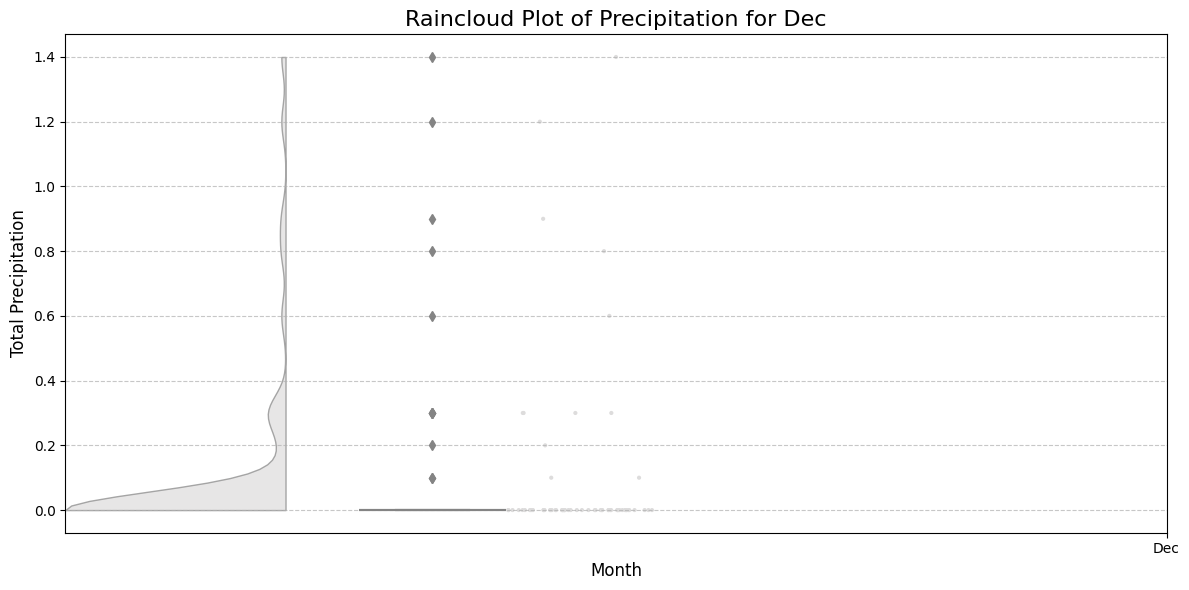

In [ ]:

# Convert 'date' column to datetime if not already
df_pivoted['date'] = pd.to_datetime(df_pivoted['date'])

# Extract the month from the 'date' column
df_pivoted['month'] = df_pivoted['date'].dt.month

# Select 'prcp' columns and add the month column
prcp_columns = [col for col in df_pivoted.columns if col.startswith("prcp_")]
df_prcp = df_pivoted.loc[:, prcp_columns + ['month']]

# Sum the precipitation values for each row
df_prcp['Total Precipitation'] = df_prcp[prcp_columns].sum(axis=1)

# Create the plots for each month
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plot each month separately
for month in range(1, 13):
    df_month = df_prcp[df_prcp['month'] == month]  # Filter data by month

    # Set up the raincloud plot for the current month
    plt.figure(figsize=(12, 6))
    pt.RainCloud(
        x="month",  # Month on x-axis
        y="Total Precipitation",  # Precipitation values on y-axis
        data=df_month,  # Filtered data for the current month
        palette="coolwarm",  # Color palette
        width_viol=0.6,  # Width of the violin plot
        width_box=0.2,  # Width of the boxplot
        alpha=0.7,  # Transparency
        move=0.2  # Overlap adjustment
    )

    # Add labels and title for the current month
    plt.title(f"Raincloud Plot of Precipitation for {month_labels[month-1]}", fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Total Precipitation", fontsize=12)
    plt.xticks(ticks=[1], labels=[month_labels[month-1]])  # Custom month label
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot for the current month
    plt.tight_layout()
    plt.show()


Accumulated Wind Direction(WDIR):

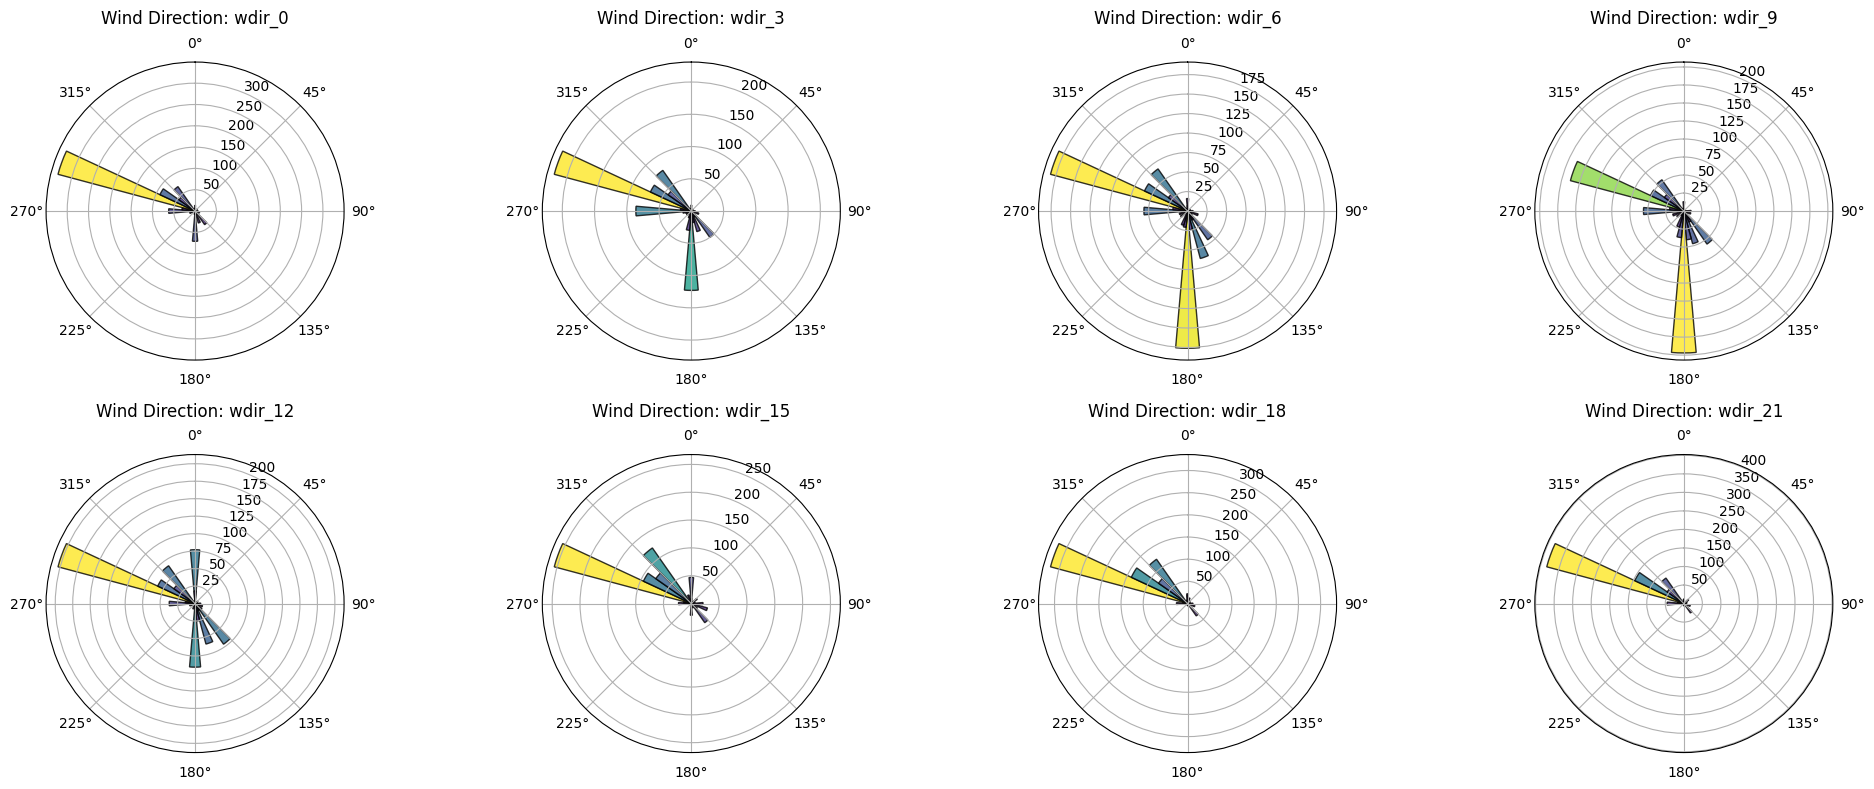

In [ ]:

# Columns of interest
columns = ['wdir_0', 'wdir_3', 'wdir_6', 'wdir_9', 'wdir_12', 'wdir_15', 'wdir_18', 'wdir_21']

# Determine layout for subplots
n_cols = 4  # Number of columns per row
n_rows = int(np.ceil(len(columns) / n_cols))  # Number of rows

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), subplot_kw={'projection': 'polar'})

# Flatten axes array for easier indexing
axes = axes.flatten()

for i, col in enumerate(columns):
    # Calculate the frequency of each wind direction
    counts = df_pivoted[col].value_counts().sort_index()  # Count sorted by degrees
    angles = np.deg2rad(counts.index)  # Convert degrees to radians

    # Normalize counts for colormap
    normalized_values = counts.values / counts.values.max()

    # Create the radial plot with a color gradient
    colors = cm.viridis(normalized_values)  # Using the Viridis colormap
    bars = axes[i].bar(angles, counts.values, width=np.deg2rad(10), color=colors, edgecolor='black', alpha=0.8)

    # Set the title for each subplot
    axes[i].set_title(f"Wind Direction: {col}", va='bottom')

    # Adjust to set 0° (North) at the top
    axes[i].set_theta_zero_location('N')
    axes[i].set_theta_direction(-1)

# Remove empty subplots if any
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Wind Speed(wspd) Distribution by Year

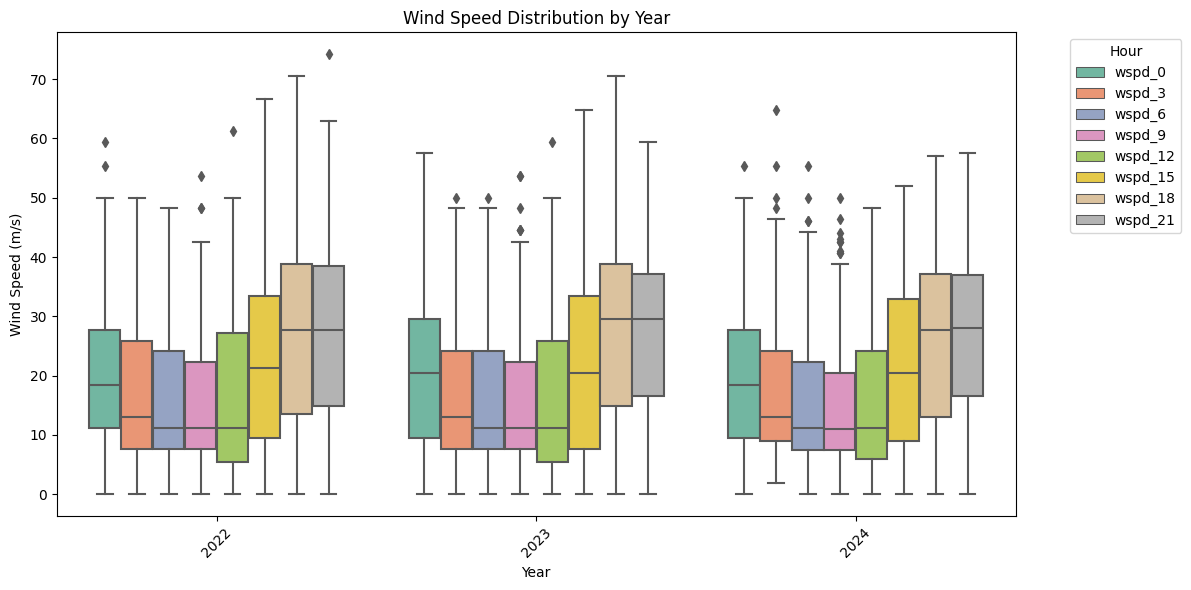

In [ ]:
# List of wind speed columns (replace these with your actual wspd columns)
wspd_cols = ['wspd_0', 'wspd_3', 'wspd_6', 'wspd_9', 'wspd_12', 'wspd_15', 'wspd_18', 'wspd_21']

# Extract the year from the 'date' column
df_pivoted['Year'] = pd.to_datetime(df_pivoted['date']).dt.year

# Melt the DataFrame so that the wind speed columns are stacked
df_melted = df_pivoted.melt(id_vars=['Year'], value_vars=wspd_cols,
                            var_name='Hour', value_name='Wind Speed')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Year', y='Wind Speed', hue='Hour', palette='Set2')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Distribution by Year')
plt.xticks(rotation=45)
plt.legend(title="Hour", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Pressure(ores) Timeline by Hour

In [ ]:
# List of pressure columns (replace these with your actual pres columns)
pres_cols = ['pres_0', 'pres_3', 'pres_6', 'pres_9', 'pres_12', 'pres_15', 'pres_18', 'pres_21']

# Convert the 'date' column to datetime if it's not already in datetime format
df_pivoted['date'] = pd.to_datetime(df_pivoted['date'])

# Melt the DataFrame so that the pressure columns are stacked
df_melted_pres = df_pivoted.melt(id_vars=['date'], value_vars=pres_cols,
                                 var_name='Hour', value_name='Pressure')

# Create the Plotly line plot
fig = px.line(df_melted_pres, x='date', y='Pressure', color='Hour',
              labels={'Pressure': 'Pressure (hPa)', 'date': 'Date', 'Hour': 'Hour of the Day'},
              title='Pressure Timeline by Hour')

# Show the plot
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Pressure (hPa)',
    legend_title='Hour',
    autosize=True
)

fig.show()


Weather Condition(coco)

In [ ]:
# Flatten all 'coco_*' columns into a single column
coco_values = df_pivoted.filter(like='coco').stack().reset_index(drop=True)

# Count the frequency of each value
frequency_df = coco_values.value_counts().reset_index()
frequency_df.columns = ['Code', 'Frequency']

# Merge the frequency DataFrame with the weather condition names
merged_df = pd.merge(frequency_df, weather_condition_df, on='Code', how='left')

# Plot the frequency of each weather condition and add text annotations for the frequency
fig = px.bar(merged_df, x='Weather Condition', y='Frequency',
             labels={'Weather Condition': 'Weather Condition', 'Frequency': 'Frequency'},
             title='Frequency of Weather Conditions')

# Add frequency value on top of each bar
fig.update_traces(text=merged_df['Frequency'], textposition='outside', texttemplate='%{text}')

# Show the plot
fig.show()

Accumulated days with and without rain:

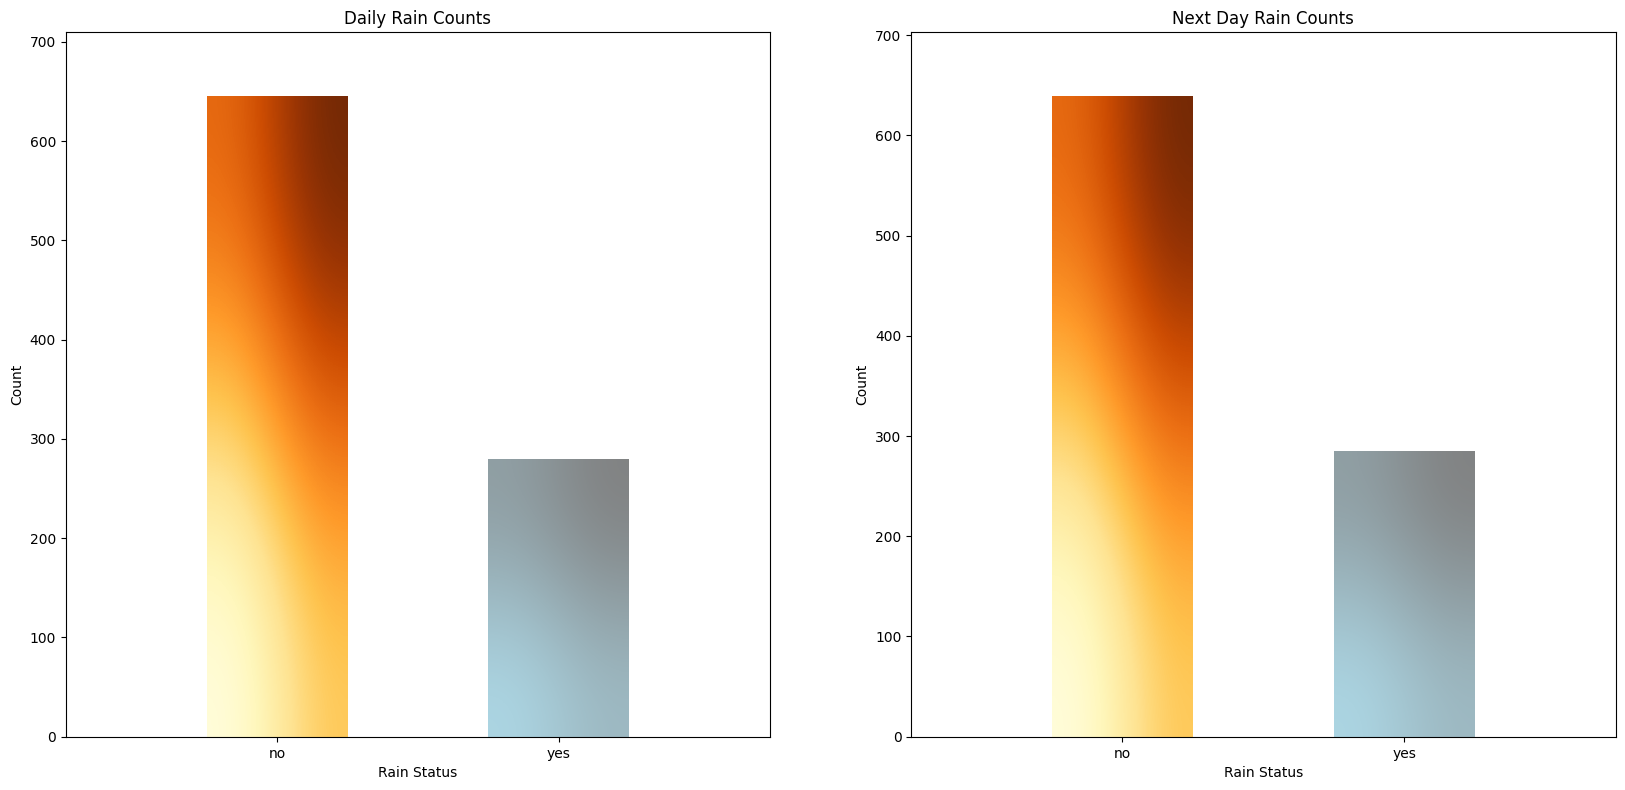

In [ ]:
def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im


def gradient_bar(ax, counts, labels, x_limits, y_max, bar_width=0.5, margin=0.2):
    # Adjust the effective range limits for the bars
    effective_range = (1 - 2 * margin) * (x_limits[1] - x_limits[0])
    center_offset = margin * (x_limits[1] - x_limits[0])
    new_x_limits = (x_limits[0] + center_offset, x_limits[1] - center_offset)

    # Calculate bar positions within the effective range
    num_bars = len(counts)
    x_positions = np.linspace(new_x_limits[0] + bar_width / 2, new_x_limits[1] - bar_width / 2, num_bars)

    # Custom colormap for 'yes' (light blue to gray)
    light_blue_to_gray = mcolors.LinearSegmentedColormap.from_list('light_blue_gray', ['#add8e6', 'gray'])  # Light blue to gray

    # Draw the gradient bars
    for left, top, label, pos in zip(x_positions - bar_width / 2, counts, labels, x_positions):
        right = left + bar_width

        # Choose the colormap based on the label
        if label == 'yes':
            cmap = light_blue_to_gray  # Custom gradient for "yes" (light blue to gray)
            cmap_range = (0, 1)
        else:
            cmap = plt.cm.YlOrBr  # Yellow gradient for "no"
            cmap_range = (0, 1)

        gradient_image(ax, extent=(left, right, 0, top), cmap=cmap, cmap_range=cmap_range)


    return x_positions

# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Get counts for each value
daily_rain_counts = df_pivoted['daily_rain'].value_counts()
next_day_rain_counts = df_pivoted['next_day_rain'].value_counts()

# Extract labels and values
daily_rain_labels = daily_rain_counts.index.tolist()
next_day_rain_labels = next_day_rain_counts.index.tolist()

# Calculate axis limits
y_limit_max_daily = daily_rain_counts.max() * 1.1
y_limit_max_next_day = next_day_rain_counts.max() * 1.1

x_limit_daily = (-y_limit_max_daily / 2, y_limit_max_daily / 2)
x_limit_next_day = (-y_limit_max_next_day / 2, y_limit_max_next_day / 2)

# Draw bars for 'daily_rain'
x_positions_daily = gradient_bar(ax[0], daily_rain_counts.values, daily_rain_labels, x_limit_daily, y_limit_max_daily, bar_width=0.2 * y_limit_max_daily, margin=0.2)

# Draw bars for 'next_day_rain'
x_positions_next_day = gradient_bar(ax[1], next_day_rain_counts.values, next_day_rain_labels, x_limit_next_day, y_limit_max_next_day, bar_width=0.2 * y_limit_max_next_day, margin=0.2)

# Configure the plots
ax[0].set_title('Daily Rain Counts')
ax[0].set_xticks(x_positions_daily)  # Use the central positions of the bars
ax[0].set_xticklabels(daily_rain_labels)
ax[0].set_xlabel('Rain Status')
ax[0].set_ylabel('Count')
ax[0].set_ylim(0, y_limit_max_daily)
ax[0].set_xlim(x_limit_daily)

ax[1].set_title('Next Day Rain Counts')
ax[1].set_xticks(x_positions_next_day)  # Use the central positions of the bars
ax[1].set_xticklabels(next_day_rain_labels)
ax[1].set_xlabel('Rain Status')
ax[1].set_ylabel('Count')
ax[1].set_ylim(0, y_limit_max_next_day)
ax[1].set_xlim(x_limit_next_day)



# Show the plot
plt.show()



Correlation between all numerical variables

In [ ]:



# Select only numerical columns
numerical_columns = df_pivoted.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,        # Values of the correlation matrix
    x=correlation_matrix.columns,       # X-axis (column names)
    y=correlation_matrix.columns,       # Y-axis (column names)
    colorscale='RdBu',                  # Color scale
    colorbar=dict(title="Correlation"), # Colorbar title
    zmin=-1, zmax=1                     # Color scale range
))

# Update the layout
fig.update_layout(
    title='Correlation Matrix Heatmap',
    xaxis=dict(
        title='Variables',
        tickangle=-45,         # Rotate x-axis labels to prevent overlap
        tickmode='array',
        tickvals=list(correlation_matrix.columns)
    ),
    yaxis=dict(
        title='Variables',
        tickmode='array',
        tickvals=list(correlation_matrix.columns)
    ),
    template='plotly_dark',             # Dark theme
    autosize=True,
    height=1200,                         # Increase the height for better spacing
    width=1200                           # Adjust the width if necessary
)

# Show the plot
fig.show()

